# Homework 3 - Boosting, Bagging, and Random Forests 

Author: Joshua Zhong

Assignment completed as part of NYU's FRE 7773 Machine Learning in Financial Engineering Course taught by Professor Amine Aboussalah

<br>

## Datasets

1. Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297. Sci-kit Learn California Housing Dataset. https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html.
2. Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

<br>

## Dependencies

In [1]:
# Import Numpy for Matrix Calculations
import numpy as np

# Import Pandas for data manipulation
import pandas as pd

# Import random for Base Python random functionality
import random

# Matplotlib library for plotting
import matplotlib.pyplot as plt

# Import UCI ML Repo to directly load datasets from library package
# !pip install ucimlrepo 
from ucimlrepo import fetch_ucirepo

# Import sklearn for loading California Housing and for comparison
from sklearn.datasets import fetch_california_housing

## Task 1: Gradient Boosting with Decision Trees

### Objective

I will be implementing a gradient boosting regressor where we'll use shallow decision trees as weak learners. We'll first build our regression trees that support MSE-based splitting and max depth/min sample splits. Then, we utilize boosting to sequentially improve predictions based on a whole collection of these regression trees, and applying it to the California Housing Dataset to predict housing prices. 

### Implementation

Gradient Boosting is an ensemble learning method that combines multiple weak learners (shallow decision trees) sequentially to create a strong predictive model. Unlike bagging which trains models in parallel to reduce variance, boosting trains models sequentially with each new model focusing on correcting the errors of the previous models. The goal is to reduce bias.

The key insight is that instead of utilizing gradient descent to optimize the weights, we are instead optimizing for the predictions. This means that when we fit each new tree, we apply gradient descent to our old prediction to get our new prediction. 

The main logic behind how to implement gradient boosting for regression is through this sequential process:
1) Initialize the model
2) Conduct iterative boosting "rounds" where we:
   - Compute the residuals (negative gradient) between actual values and current predictions
   - Fit a decision tree to predict these residuals
   - Update the model by adding the tree's predictions scaled by the learning rate
   - Repeat for a set hyperparameter number of times
3) Final prediction is the sum of the initial prediction plus all the weighted tree predictions

#### MSE-Based Splitting for Regression Trees

For regression trees, we use Mean Squared Error (MSE) as our splitting criterion. The MSE measures how much the values in a node deviate from the mean prediction for that node. A good split minimizes the weighted average MSE of the resulting child nodes.

The MSE for a node is calculated as:
<center>$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2$</center>
<br>
where $\bar{y}$ is the mean of the target values in that node.
<br><br>
For a potential split, we calculate the reduction in MSE:
<center>$\text{MSE Reduction} = \text{MSE}_{parent} - \text{Weighted MSE}_{children}$</center>
<br>
We select the split that maximizes this reduction (i.e., gives us the lowest weighted child MSE).

In [2]:
# Function that calculates MSE for a given node (represented as an array)
def calculate_mse(y):
    # y represents an array of target values 

    if len(y) == 0: # Edge case, empty array 
        return 0 

    # Still not sure if np.mean() allowed, manual loop
    n = len(y)
    avg = 0.0

    # Calculate average
    for i in range(n): 
        avg += y[i]
    avg = avg / n

    # Loop through and sum up squared residuals
    mse = 0.0
    for i in range(n):
        mse += (y[i] - avg)**2


    return mse / n # Return MSE of array y

#### Regression Tree Implementation

Now I'll implement the core functions for building regression trees. These trees will be the "weak learners" in our gradient boosting ensemble. Each tree will be relatively shallow (controlled by max_depth) to prevent overfitting and ensure they remain weak learners.

The key difference from classification trees is that our leaf nodes will output the mean value of the samples that end up in that node, rather than a class label. This is the Regression part when we say Classification and Regression Tree (CART) algorithms. 

In [3]:
# Split the dataset based on a feature and threshold, from Homework 2
def split_data(X, y, column, threshold):
    # X represents feature matrix
    # y represents targets
    # column represents the feature column we're splitting on 
    # threshold is the value we're splitting on 

    # Compare column values against threshold
    left_indices = X[:, column] <= threshold # Boolean arrays for left branch
    right_indices = X[:, column] > threshold # Boolean arrays for right branch
    
    return left_indices, right_indices # Returns indices for left and right splits

In [4]:
# Calculates tree split based on MSE reduction to find best feature and threshold to split on, from hwk2
def find_best_split(X, y, min_samples_split):
    # X represents feature matrix
    # y represents targets (continuous values for regression)
    # min_samples_split represents minimum samples required to make a split

    # Initialize local variables that track the best feature and threshold based on best MSE reduction
    best_mse_reduction = -1
    best_feature = None
    best_threshold = None

    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    # Calculate initial MSE of current node
    current_mse = calculate_mse(y)
    
    # Nested for loop which tests every feature/column and threshold
    for column in range(n_features):
        
        # Get unique values for this feature to use as potential thresholds
        unique_values = np.unique(X[:, column])
        
        # Brute force attempt of threshold on that given feature 
        for threshold in unique_values:
            
            # Split the data
            left_indices, right_indices = split_data(X, y, column, threshold)
            
            # Check if all data would split to left or right branch as there's no point splitting
            n_left = np.sum(left_indices)
            n_right = np.sum(right_indices)
            
            if n_left == 0 or n_right == 0:
                continue # go to next loop iteration
            
            # Check minimum samples constraint
            if n_left < min_samples_split or n_right < min_samples_split:
                continue

            # Checks made, node needs to be split if iteration reaches here
            
            # Calculate MSE for left and right splits
            y_left = y[left_indices]
            y_right = y[right_indices]
            
            left_mse = calculate_mse(y_left)
            right_mse = calculate_mse(y_right)
                
            # Calculate weighted average MSE
            weighted_mse = (n_left / n_samples) * left_mse + (n_right / n_samples) * right_mse
            
            # Calculate MSE reduction
            mse_reduction = current_mse - weighted_mse
            
            # Update best split if current reduction is better
            if mse_reduction > best_mse_reduction:
                best_mse_reduction = mse_reduction
                best_feature = column
                best_threshold = threshold
    
    return best_feature, best_threshold, best_mse_reduction # Returns the best split

In [5]:
# Helper function to calculate mean value of target array y
def calculate_mean(y):
    # y represents the array of target values at a given node 
    
    if len(y) == 0:
        return 0.0
    
    # Calculate mean via loop
    total = 0.0
    for i in range(len(y)):
        total += y[i]
    
    return total / len(y) # Return the mean value

In [6]:
# The "main" function where we're recursively building our tree given initial hyperparameters, from hwk2
def build_tree(X, y, max_depth, min_samples_split, current_depth):
    # X represents feature matrix
    # y represents targets (continuous for regression)
    # max_depth represents the stopping criteria limiting max branch length
    # min_samples_split represents the stopping criteria ensuring that nodes aren't too small
    # current_depth represents length of current branch - this helps with keeping track of depth
    
    # Local variables needed for stopping criteria 
    n_samples = len(y)
    
    # Stopping criteria, we need to check these first before splitting
    # Stops if max depth reached or not enough samples to split
    if (max_depth is not None and current_depth >= max_depth) or n_samples < min_samples_split:
        # Reaching here means that stopping criteria has been hit, so spawn leaf node
        
    # Create leaf node with mean value
        leaf_value = calculate_mean(y)
        return {'type': 'leaf', 'value': leaf_value}

    # Stopping criteria has not been met here, thus we continue splitting
    
    # Find best split
    best_feature, best_threshold, best_mse_reduction = find_best_split(X, y, min_samples_split)
    
    # If no good split can be made, create a leaf node
    if best_feature is None or best_mse_reduction <= 0:
        leaf_value = calculate_mean(y)
        return {'type': 'leaf', 'value': leaf_value}
    
    # Call our split_data helper function to split
    left_indices, right_indices = split_data(X, y, best_feature, best_threshold)

    # Make recursive call to subtrees in the next depth 
    left_subtree = build_tree(X[left_indices], y[left_indices], max_depth, min_samples_split, current_depth + 1)
    right_subtree = build_tree(X[right_indices], y[right_indices], max_depth, min_samples_split, current_depth + 1)

    # Create internal node
    return {                         
        'type': 'internal',          # Whether node is internal or leaf node
        'feature': best_feature,     # Store best feature of said node
        'threshold': best_threshold, # Stores best threshold for the best feature 
        'left': left_subtree,        # Stores left child 
        'right': right_subtree       # Stores right child
    }

#### Prediction on test samples

Now, we create functions that make predictions by traversing the decision tree. Unlike for classification, leaf nodes will return mean values instead of class labels.

In [7]:
def predict_tree(X, tree):
    # X represents the matrix of predictor values
    # tree represents our decision tree (although it's technically "just" the root node)

    n = X.shape[0] # total sample size
    y_predict = np.zeros(n) # our predictions array
    
    # For loop across the samples 
    for i in range(n):
        y_predict[i] = traverse_tree(tree, X[i]) # We pass our root node and the current sample and store prediction in y_predict
        
    return y_predict # returns a float value for prediction

In [8]:
# Recursive logic which eventually retrieves the preidction value
def traverse_tree(current_node, sample):
    # current_node represents a dictionary representing the internal node that we're given
    # sample represents the feature values for a single sample    
    
    # Check if node is a leaf and return predicted label, this will "terminate" the recursion
    if current_node['type'] == 'leaf':
        return current_node['value']

    # Get next child based on checking current node's features and values
    feature = current_node['feature']
    threshold = current_node['threshold']

    # Check if the sample's value for specified feature meets threshold
    if(sample[feature] <= threshold):
        return traverse_tree(current_node['left'], sample) # Gives recursive left child subtree
    else:
        return traverse_tree(current_node['right'], sample) # Gives recursive right child subtree 

#### Gradient Boosting Implementation

We construct our prediction function as a sum of base learners:
<center>$F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot h_m(x)$</center><br>
Where $F_{0}(x)$ is our initial prediction, $h_{m}(x)$ is the m-th decision tree, $\eta$ is the learning rate, and M is the total number of boosting rounds.
<br>

At each iteration, we want to update our model to reduce the loss. For a general loss function $\mathcal{L}(y, F(x))$, we compute the negative gradient (also called the pseudo-residual):

<center>$r_{im} = -\frac{\partial \mathcal{L}(y_i, F(x_i))}{\partial F(x_i)} \bigg|_{F=F_{m-1}}$</center><br>
For squared error loss, $\mathcal{L}(y, F) = 0.5(y - F)^2$, which simplifies to:<br>
<br>
<center>$r_{im} = -\frac{\partial}{\partial F}\left[\frac{1}{2}(y_i - F_{m-1}(x_i))^2\right] = y_i - F_{m-1}(x_i)$</center><br>

This is simply the residual, the difference between the true value and our current prediction. If we knew the true residuals for all possible inputs, we could use the following equation to directly update our values:
<center>$F_{new}(x) = F_{old}(x) + \eta \cdot (y - F_{old}(x))$</center><br>
However, this is not possible for unseen data points where y is unknown. Instead, we train a decision tree $h_{m}(x)$ on our training data to learn the mapping from features x to residuals r. This allows the model to generalize the residual pattern to new observations.

Instead, we do the following:

1. Initialize with a constant prediction (the mean of the target):

<center>$F_0(x) = \bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i$</center><br>

2. For each boosting round m=1,2,...,M:

- Compute residuals for each training sample: <center>$r_{im} = y_i - F_{m-1}(x_i)$</center><br>
- Fit a regression tree $h_{m}(x)$ to the residuals $\{(x_i, r_{im})\}_{i=1}^{n}$<br><br>
- Update the model: <center>$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$</center><br>

3. Output the final model $F_{M}(x)$

The learning rate $\eta \in (0,1]$ controls the contribution of each tree. A smaller learning rate requires more trees but typically results in better generalization by preventing overfitting to early residuals. Finding the optimal learning rate is important—too large and we "jump" past the minimum, too small and training becomes prohibitively expensive. This is analogous to the step size in traditional gradient descent.
<br><br>
One more thing we can do to further reduce overfitting and improve generalization is to train each tree on a random subsample of the training data. This introduces randomness similar to stochastic gradient descent and is controlled by the subsample ratio parameter.

In [9]:
# Hwk 2 + Claude intuition help 
def train_gradient_boosting(X_train, y_train, n_estimators, learning_rate, max_depth, min_samples_split, subsample_ratio=1.0, random_seed=None):
    # X_train represents the training feature matrix
    # y_train represents the training target values
    # n_estimators represents the number of boosting rounds (trees)
    # learning_rate represents the step size for each tree's contribution
    # max_depth represents the maximum depth of each tree
    # min_samples_split represents minimum samples required to split a node
    # subsample_ratio represents the fraction of samples to use for each tree
    # random_seed for reproducibility
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_samples = X_train.shape[0]
    
    # Step 1: Initialize with the mean of target values
    initial_prediction = calculate_mean(y_train)
    
    # Current predictions for all training samples, start with the mean
    current_predictions = np.full(n_samples, initial_prediction) # Vectorized, Claude suggestion
    
    # Store all trees and training errors
    trees = []
    
    # Main looping behavior, continually compute residual, fit tree, then update 
    for m in range(n_estimators):
        
        # Step 2: Compute residuals (negative gradient of squared error loss)
        residuals = y_train - current_predictions
        
        # Subsampling: randomly select a subset of training data; Claude
        if subsample_ratio < 1.0:
            n_subsample = int(n_samples * subsample_ratio)
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            subsample_indices = indices[:n_subsample]
            X_subsample = X_train[subsample_indices]
            residuals_subsample = residuals[subsample_indices]
        else:
            X_subsample = X_train
            residuals_subsample = residuals
        
        # Step 3: Fit a tree to the residuals
        tree = build_tree(X_subsample, residuals_subsample, max_depth, min_samples_split, 0)
        trees.append(tree)
        
        # Step 4: Update predictions
        tree_predictions = predict_tree(X_train, tree)
        current_predictions = current_predictions + learning_rate * tree_predictions
        

    
    # Return model as a dictionary containing 3 items: the starting prediction, the list of trees, and the learning rate
    model = {
        'initial_prediction': initial_prediction,
        'trees': trees,
        'learning_rate': learning_rate
    }
    
    return model # returns trained model

In [10]:
# Given a matrix of features and a gradient boosting model, calculate and returns list of corresponding predictions 
def predict_gradient_boosting(X, model):
    # X represents the feature matrix to make predictions on
    # model represents our trained gradient boosting model dictionary
    
    n_samples = X.shape[0]
    
    # Start with initial prediction
    predictions = np.full(n_samples, model['initial_prediction']) 
    
    # Vectorized operation rather than explicit for loop 
    for tree in model['trees']:
        tree_predictions = predict_tree(X, tree)
        predictions = predictions + model['learning_rate'] * tree_predictions # perform element-wise operations 
    
    return predictions # returns list of predictions

### Application & Evaluation

Now we get to apply data to our gradient boosting algorithm! We will load the California Housing dataset, split it into training and test sets, train models with different numbers of boosting rounds, and evaluate their performance.

#### Import and Preprocess Dataset

First, we import the data using Scikit-Learn's built-in "fetch_california_housing()" function

In [11]:
# Load California Housing Dataset
california = fetch_california_housing()
X = california.data
y = california.target

# Preliminary EDA
print("California Housing Dataset Shape:")
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Feature names:", california.feature_names)
print("Total NaN values:", np.isnan(X).sum())

California Housing Dataset Shape:
Features shape: (20640, 8)
Target shape: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Total NaN values: 0


The California Housing dataset has 20,640 samples, which turned out to be large enough to cause the algorithm to run at a snail's pace, even with "only" 5 boosting rounds. The reason is likely to do with my implementation for the "find_best_split" function, which includes a nested for loop which would run at O($N^2$) time complexity.

#### Simple Random Sample

For simplicity, I will perform a subset of 2064 samples from the original dataset to reduce time taken for computation. While this isn't technically rigorous as there's no formal justification to performing this, it will allow for the code to be run in a quicker manner and nevertheless demonstrate the capabilities of the algorithm. We employ simple random sample because the target variable is roughly balanced. 

In [12]:
california_y, count_y = np.unique(california.target, return_counts = True)

print(california_y, count_y)

[0.14999 0.175   0.225   ... 4.991   5.      5.00001] [  4   1   4 ...   1  27 965]


In [13]:
# Subset 2064 observations to reduce runtime
np.random.seed(88)

# Rearrange indices, get 2064 random indices
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
subset_indices = indices[:2064]

# Get the observations corresponding to those indices
X_subset = X[subset_indices]
y_subset = y[subset_indices]

#### Train/Test Split

Next, we will split the data into training and test datasets.

In [14]:
# Train/test split function (70/30), hwk2
def train_test_split(X, y, train_ratio=0.70, random_seed=None):
    # X represents the feature matrix size number of samples by number of features
    # y represents the target vector with length equal to number of samples
    # train_ratio represents the proportion of data allocated to training set
    # random_seed is an optional parameter for reproducibility

   
    # Set random seed if provided for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = X.shape[0]  # Total number of samples
    
    # Create array of indices from 0 to n-1 and shuffle them randomly
    indices = np.arange(n)
    np.random.shuffle(indices)  # In-place randomization

    # Calculate the split points based on ratios
        # Remaining samples go to test set
    train_end = int(n * train_ratio)
    
    # Split the indices into two groups
    train_indices = indices[:train_end]
    test_indices = indices[train_end:]

    # Apply the shuffled indices to X and y to create the splits
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test   # Outputs the split datasets according to shuffled indices where X and y rows align

We call our train_test_split function to split our value with random seed 88. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, 0.7, 88)

#### Train Gradient Boosting Models with Different Boosting Rounds

Now we'll train our graident boosting models with various boosting rounds (5, 10, 50, 100) to evaluate how performance differs given this change in hyperparameter. We will keep the other hyperparameters constant (learning rate = 0.1, max depth of 3, minimum sample split of 2, and subsample ratio of 0.8) to guage how changing the number of rounds specifically affects performance. 

In [16]:
# Hyperparameters
learning_rate = 0.1
max_depth = 3
min_samples_split = 2
subsample_ratio = 0.8

### Model with 5 Boosting Rounds
# Train model
model_5 = train_gradient_boosting(X_train, y_train, 5, learning_rate, 
                                max_depth, min_samples_split, subsample_ratio, random_seed=88)
# Make predictions
y_pred_train_5 = predict_gradient_boosting(X_train, model_5)
y_pred_test_5 = predict_gradient_boosting(X_test, model_5)

In [17]:
### Model with 10 Boosting Rounds
# Train model
model_10 = train_gradient_boosting(X_train, y_train, 10, learning_rate, 
                                max_depth, min_samples_split, subsample_ratio, random_seed=88)
# Make predictions
y_pred_train_10 = predict_gradient_boosting(X_train, model_10)
y_pred_test_10 = predict_gradient_boosting(X_test, model_10)

In [18]:
### Model with 50 Boosting Rounds
# Train model
model_50 = train_gradient_boosting(X_train, y_train, 50, learning_rate, 
                                max_depth, min_samples_split, subsample_ratio, random_seed=88)
# Make predictions
y_pred_train_50 = predict_gradient_boosting(X_train, model_50)
y_pred_test_50 = predict_gradient_boosting(X_test, model_50)

In [19]:
### Model with 100 Boosting Rounds
# Train model
model_100 = train_gradient_boosting(X_train, y_train, 100, learning_rate, 
                                max_depth, min_samples_split, subsample_ratio, random_seed=88)
# Make predictions
y_pred_train_100 = predict_gradient_boosting(X_train, model_100)
y_pred_test_100 = predict_gradient_boosting(X_test, model_100)

#### Evaluate Performance

For regression problems, we evaluate the performance using the following metrics:

Root Mean Squared Error (RMSE) measures the square root of the average squared differences between predicted and actual values:
<center>$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$</center>
<br>

Mean Absolute Error (MAE) measures the average absolute differences between predicted and actual values:
<center>$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$</center>
<br>

R-squared (R²) measures the proportion of variance in the target variable explained by the model:
<center>$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$</center>
<br>

In [20]:
def compute_rmse(y_true, y_pred):
    # y_true is the array of the actual target values
    # y_pred is the array of the predicted values
    
    n = len(y_true)
    squared_errors = 0.0
    
    # Loop through and sum squared errors
    for i in range(n):
        squared_errors += (y_true[i] - y_pred[i]) ** 2
    
    mse = squared_errors / n
    return np.sqrt(mse) # Return RMSE


def compute_mae(y_true, y_pred):
    # y_true is the array of the actual target values
    # y_pred is the array of the predicted values
    
    n = len(y_true)
    absolute_errors = 0.0
    
    # Loop through and sum absolute errors
    for i in range(n):
        absolute_errors += abs(y_true[i] - y_pred[i])
    
    return absolute_errors / n # Return MAE


def compute_r2(y_true, y_pred):
    # y_true is the array of the actual target values
    # y_pred is the array of the predicted values
    
    n = len(y_true)
    
    # Calculate mean of y_true
    y_mean = calculate_mean(y_true)
    
    # Calculate SS_res (sum of squared residuals) and SS_tot (total sum of squares)
    ss_res = 0.0
    ss_tot = 0.0

    # Loops through SS_res and SS_tot for each observation
    for i in range(n):
        ss_res += (y_true[i] - y_pred[i]) ** 2
        ss_tot += (y_true[i] - y_mean) ** 2
    
    # Avoid division by zero
    if ss_tot == 0:
        return 0.0
    
    return 1 - (ss_res / ss_tot) # Return R-squared

Now, we get the evaluation metrics on our models with various boosting rounds. 

In [21]:
# 5 Boosting Rounds
print("Results for 5 boosting rounds:")
print("\nTrain RMSE: ", compute_rmse(y_train, y_pred_train_5))
print("Test RMSE: ", compute_rmse(y_test, y_pred_test_5))
print("Test MAE: ", compute_mae(y_test, y_pred_test_5))
print("Test R^2: ", compute_r2(y_test, y_pred_test_5))

# 10 Boosting Rounds
print("\nResults for 10 boosting rounds:")
print("Train RMSE: ", compute_rmse(y_train, y_pred_train_10))
print("Test RMSE: ", compute_rmse(y_test, y_pred_test_10))
print("Test MAE: ", compute_mae(y_test, y_pred_test_10))
print("Test R^2: ", compute_r2(y_test, y_pred_test_10))

# 50 Boosting Rounds
print("\nResults for 50 boosting rounds:")
print("Train RMSE: ", compute_rmse(y_train, y_pred_train_50))
print("Test RMSE: ", compute_rmse(y_test, y_pred_test_50))
print("Test MAE: ", compute_mae(y_test, y_pred_test_50))
print("Test R^2: ", compute_r2(y_test, y_pred_test_50))

# 100 Boosting Rounds
print("\nResults for 100 boosting rounds:")
print("Train RMSE: ", compute_rmse(y_train, y_pred_train_100))
print("Test RMSE: ", compute_rmse(y_test, y_pred_test_100))
print("Test MAE: ", compute_mae(y_test, y_pred_test_100))
print("Test R^2: ", compute_r2(y_test, y_pred_test_100))

Results for 5 boosting rounds:

Train RMSE:  0.8733862499178315
Test RMSE:  0.9139337927097463
Test MAE:  0.7061807255762479
Test R^2:  0.33739918563711757

Results for 10 boosting rounds:
Train RMSE:  0.746246251633441
Test RMSE:  0.8073368899201226
Test MAE:  0.6118515801920665
Test R^2:  0.4829505403646891

Results for 50 boosting rounds:
Train RMSE:  0.4918072644704827
Test RMSE:  0.636047177625351
Test MAE:  0.4456275159950079
Test R^2:  0.6790767707034514

Results for 100 boosting rounds:
Train RMSE:  0.4050802632140722
Test RMSE:  0.6112879518631348
Test MAE:  0.42084272940947964
Test R^2:  0.7035754519824255


Rather unsurprisingly, we see that the Train RMSE's performs better than our Test RMSE's. We also see that with a higher number of boosting rounds, we get better performance metrics. However, it appears as though while the gap between 5 to 10 and 10 to 50 rounds are quite significant, the difference between 50 and 100 rounds seems to be a much smaller improvement. 

This indicates that there is likely a diminishing return in the number of rounds: that while it may perform better the higher the number of rounds, the marginal improvement from increasing rounds decreases. 

#### Plotting Scatterplot and Training Errors across Boosting Rounds

Let's plot the scatterplot to take a look at how well it performs across boosting rounds. 

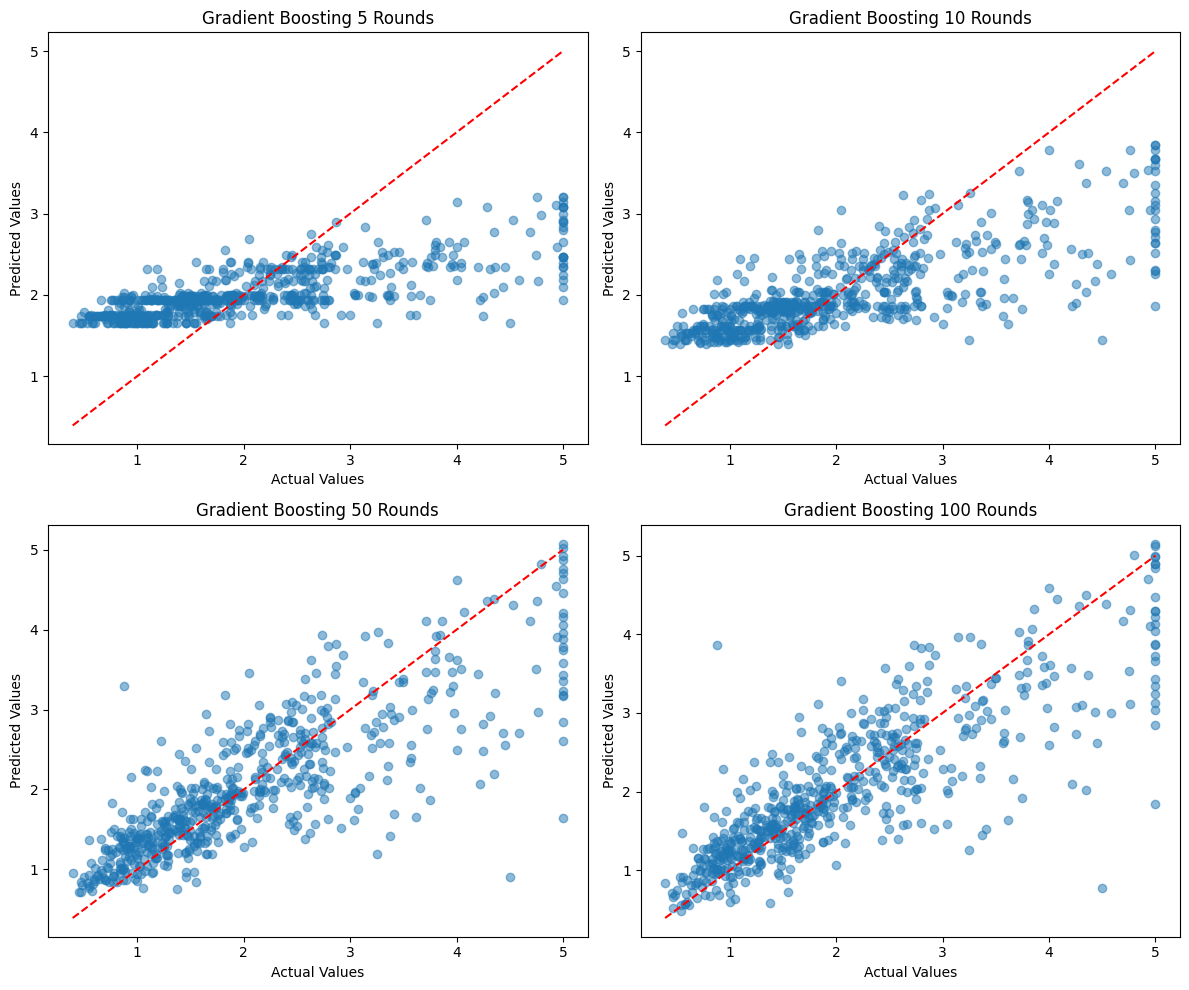

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Needed for subplots to work properly

# 5 Rounds
axes[0].scatter(y_test, y_pred_test_5, alpha=0.5)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Gradient Boosting 5 Rounds')

# 10 Rounds
axes[1].scatter(y_test, y_pred_test_10, alpha=0.5)
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Gradient Boosting 10 Rounds')

# 50 Rounds
axes[2].scatter(y_test, y_pred_test_50, alpha=0.5)
axes[2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')
axes[2].set_title('Gradient Boosting 50 Rounds')

# 100 Rounds
axes[3].scatter(y_test, y_pred_test_100, alpha=0.5)
axes[3].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
axes[3].set_xlabel('Actual Values')
axes[3].set_ylabel('Predicted Values')
axes[3].set_title('Gradient Boosting 100 Rounds')

plt.tight_layout()
plt.show()

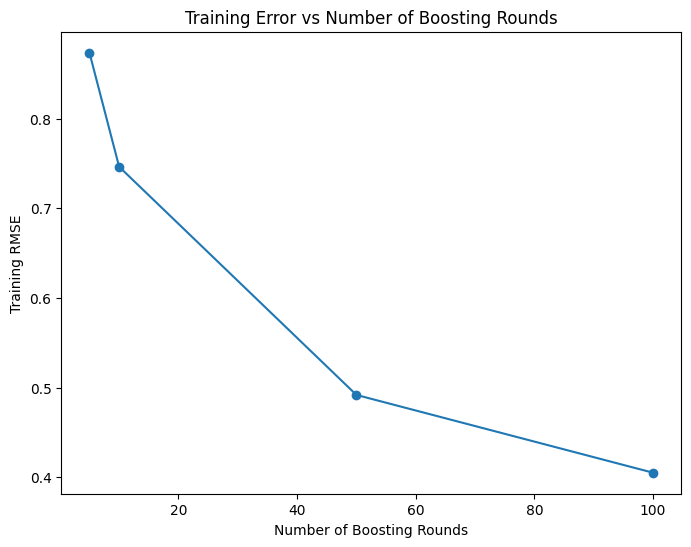

In [23]:
# Final training RMSE for each model size
train_rmses = [
    compute_rmse(y_train, y_pred_train_5),
    compute_rmse(y_train, y_pred_train_10),
    compute_rmse(y_train, y_pred_train_50),
    compute_rmse(y_train, y_pred_train_100)
]

plt.figure(figsize=(8, 6))
plt.plot([5,10,50,100], train_rmses, marker='o')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Training RMSE')
plt.title('Training Error vs Number of Boosting Rounds')
plt.show()

We can see that the biggest difference is between 10 and 50 boosting rounds. This makes sense as 10 is ultimately too little to effectively create any valuable prediction, but these 40 additional rounds have much larger impact than the subsequent 50 rounds between 50 and 100 (as we observed in the evaluation metrics). 

#### Compare to Sci-kit Learn's GradientBoostingRegressor

We'll now benchmark our gradient boosting implementation against scikit-learn's GradientBoostingRegressor. This comparison will evaluate both performance metrics and examine how much more optimized Sklearn's optimization is. I completely expect Sklearn's to be faster. My implementation has O($N^2$) time complexity for each tree node due to the threshold check every time. 

Sklearn performs the following optimizations: 
- Pre-sorts each feature's data at the start, which makes finding the best split an O^($N$) operation, which is significantly faster
- Bins values for each threshold instead of considering each individual value for the threshold
- Code written in C, significantly faster than a higher-level language such as Python
- Vectorizes operations, which reduces Python Interpreter overhead 

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# Train sklearn model with same hyperparameters

n_rounds = [5,10,50,100]

# loop through for each round instead of manually code
for n in n_rounds:
    sklearn_gb = GradientBoostingRegressor(
        n_estimators=n,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        subsample=subsample_ratio,
        random_state=88
    )
    sklearn_gb.fit(X_train, y_train)
    
    # Predictions
    sklearn_pred_train = sklearn_gb.predict(X_train)
    sklearn_pred_test = sklearn_gb.predict(X_test)
    
    # Evaluation Metrics Comparison
    print("Results for ", n, " Rounds")
    print("Train RMSE: ", compute_rmse(y_train, sklearn_pred_train))
    print("Test RMSE: ", compute_rmse(y_test, sklearn_pred_test))
    print("Test MAE: ", compute_mae(y_test, sklearn_pred_test))
    print("Test R^2: ", compute_r2(y_test, sklearn_pred_test))

Results for  5  Rounds
Train RMSE:  0.8743845036466968
Test RMSE:  0.914768326194552
Test MAE:  0.7050092105722852
Test R^2:  0.3361885617772027
Results for  10  Rounds
Train RMSE:  0.7472492092579933
Test RMSE:  0.81272193779769
Test MAE:  0.614189765166236
Test R^2:  0.4760299547155905
Results for  50  Rounds
Train RMSE:  0.481258568864022
Test RMSE:  0.6245271966739269
Test MAE:  0.43580577814338894
Test R^2:  0.6905965120839351
Results for  100  Rounds
Train RMSE:  0.4026787427673461
Test RMSE:  0.604674759950714
Test MAE:  0.41459941065817557
Test R^2:  0.7099544707104621


These results show that my gradient boosting implementation produces marginally worse results against Sci-kit learn's algorithm in terms of 100 rounds of gradient boosting; however, sklearn's version is significantly more optimized. While my implementation took upwards of 3-5 minutes to fully run, the sklearn implementation was done in less than 10 seconds.

Key observations:
- More boosting rounds generally lead to better performance (lower RMSE, higher R²)
- The learning rate of 0.1 was solid, though in the future a grid search could be used to optimize which hyperparameters to use
- Shallow trees (max depth of 3) work well as weak learners
- Subsampling helps with regularization and can prevent overfitting

## Task 2: Random Forest Implementation

### Objective

I will be implementing a Random Forest classifier using my previous homework's decision tree implementation as the base learner. The implementation will include bootstrap sampling, random feature selection at each split, and majority voting for aggregation. I'll apply it to the UCI Bank Marketing dataset for binary classification (predicting whether a client will subscribe to a term deposit).

### Implementation

Random Forest is an ensemble learning method that combines multiple decision trees trained on different bootstrap samples of the data. Unlike gradient boosting which trains trees sequentially, Random Forest trains trees in parallel and uses their average/majority vote for predictions.

The key improvements of Random Forest over just a Decision Tree (CART):
1) Bootstrap sampling: Each tree is trained on a random sample (sampling **with** replacement) of the training data
2) Random feature selection: At each split, only a random subset of features is considered

These two sources of randomness help decorrelate the trees, helping to reduce overfitting by reducing the variance and prediction errors.

#### Gini and Splitting Criteria

For classification, we'll use Gini impurity as our splitting criterion:

<center>$\text{Gini}(S) = 1 - \sum_{i=1}^{C} p_i^2$</center>
<br>
where $p_i$ is the probability of class $i$ in set $S$.

In [25]:
# Function that calculates the gini coefficient for a specific array
def calculate_gini(y):
    # y represents an array of labels at any given node
    
    if len(y) == 0: # Check for empty node
        return 0

    n = len(y) # Total elements count
    c = np.unique(y) # Unique classes/labels
    gini = 0.0

    # # Summing logic, add up label proportions for all labels
    # for label in c: 
    #     temp = 0.0
    #     for i in range(len(y)):
    #         if y[i] == label:
    #             temp += 1

    #     gini += (temp/n) * (temp/n)

    # return 1 - gini # Return gini impurity

    # Claude, optimized to O(N), trying to diagnose why it's performance is so poor
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs * probs)

In [26]:
# Split the dataset based on a feature and threshold
def split_data(X, y, column, threshold):
    # X represents feature matrix
    # y represents targets
    # column represents the feature column we're splitting on 
    # threshold is the value we're splitting on 

    left_indices = X[:, column] <= threshold
    right_indices = X[:, column] > threshold
    
    return left_indices, right_indices

In [27]:
# Find best split considering only a random subset of features; hwk2
def find_best_split(X, y, n_features_split):
    # X represents feature matrix
    # y represents targets
    # n_features_split is the number of random features to consider at each split

    best_gain = -1
    best_feature = None
    best_threshold = None

    n_samples = X.shape[0]
    total_features = X.shape[1]
    
    # Calculate initial Gini impurity
    current_gini = calculate_gini(y)
    
    # Randomly subset of features at each split for randomness
    all_features = list(range(total_features))
    random.shuffle(all_features)
    random_features = all_features[:n_features_split]

    
    # Only consider the randomly selected features
    for column in random_features:
        
        # unique_values = np.unique(X[:, column])

        # midpoint thresholds; Claude
        col_values = np.sort(np.unique(X[:, column]))
        thresholds = (col_values[:-1] + col_values[1:]) / 2
        
        for threshold in thresholds:
            
            left_indices, right_indices = split_data(X, y, column, threshold)

            # All values split to one side, skip to next iteration
            if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                continue

            # Calculate weighted Gini
            y_left = y[left_indices]
            y_right = y[right_indices]
            
            left_gini = calculate_gini(y_left)
            right_gini = calculate_gini(y_right)
            
            n_left = len(y_left)
            n_right = len(y_right)
            
            weighted_gini = (n_left / (n_left + n_right)) * left_gini + (n_right / (n_left + n_right)) * right_gini
            gain = current_gini - weighted_gini

            # Update parameters if information gain occured 
            if gain > best_gain:
                best_gain = gain
                best_feature = column
                best_threshold = threshold
    
    return best_feature, best_threshold, best_gain # return relevant info (feature/threshold/gain) for best split

In [28]:
# Hwk 2
def find_majority_class(y):
    # y represents the array of class labels at a given node 

    # Local variables to track 
    c = np.unique(y) # Array of unique labels
    counts = np.zeros(len(c)) # Track counts for each label, initialized to 0s
    most = -1 # Tracks best count
    best = -1 # Tracks best label

    # Loop through all of y
    for i in range(len(y)): 
        label = y[i]
        for j in range(len(c)): # Loop to identify which label and increment that label's count
            if c[j] == label:
                counts[j] += 1
                break # Applied count, can move on to next label in y
                
    # Find index with highest count
    for i in range(len(counts)):
        if counts[i] > most:
            most = counts[i]
            best = i

    return c[best]  # Return the best label based on its index from counts

#### Building a Decision Tree

The idea behind the building of the tree is nearly identical to the Decision Tree architecture, with minor differences in the end goal behind finding the best split (include the number of features to subset on). 

In [29]:
# Hwk 2, same idea of recursive tree built
def build_tree(X, y, max_depth, min_samples_split, n_features_split, current_depth):
    # X represents feature matrix
    # y represents targets (class labels)
    # max_depth represents the maximum depth of the tree
    # min_samples_split represents minimum samples required to split
    # n_features_split represents number of features to consider at each split
    # current_depth represents current depth in the tree

    # Local variables (to this branch) needed for stopping criteria 
    n_samples = len(y)
    n_classes = len(np.unique(y))
    
    # Stopping criteria; if 100% pure or meets other stopping criteria, create leaf node
    if (max_depth is not None and current_depth >= max_depth) or n_samples < min_samples_split or n_classes == 1:
        leaf_value = find_majority_class(y)     
        return {'type': 'leaf', 'value': leaf_value}

    # Find best split, main difference here is not criterion but rather # of features to split on 
    best_feature, best_threshold, best_gain = find_best_split(X, y, n_features_split)

    # Safety check for if no good split could be made, leaf node
    if best_feature is None or best_gain <= 0:
        leaf_value = find_majority_class(y)     
        return {'type': 'leaf', 'value': leaf_value}

    # Call our split_data helper function to split
    left_indices, right_indices = split_data(X, y, best_feature, best_threshold)

    # Make recursive call to subtrees in the next depth 
    left_subtree = build_tree(X[left_indices], y[left_indices], max_depth, 
                              min_samples_split, n_features_split, current_depth + 1)
    right_subtree = build_tree(X[right_indices], y[right_indices], max_depth, 
                             min_samples_split, n_features_split, current_depth + 1)

    # Create internal node
    return {                         # We use dictionaries as our data structure for our nodes
        'type': 'internal',          # Identifies that the node is not a leaf node
        'feature': best_feature,     # Identifies which feature should be checked at this node
        'threshold': best_threshold, # Identifies what value for that feature to check at this node
        'left': left_subtree,        # Gives left child of this node
        'right': right_subtree       # Gives right child of this node
    }

#### Prediction on Test Samples

Similarly to our random forest algorithm, we also need to perform predictions and traversion. 

In [30]:
def predict(X, tree):
    # X represents the matrix of predictor values
    # tree represents our decision tree (although it's technically "just" the root node)

    n = X.shape[0] # total sample size
    y_predict = np.zeros(n) # our predictions array
    
    # For loop across the samples 
    for i in range(n):
        y_predict[i] = traverse_tree(tree, X[i]) # We pass our root node and the current sample and store prediction in y_predict

        
    return y_predict.astype(int) # returns explicitly integers for the label predictions

In [31]:
# Recursive logic which eventually retrieves the prediction value
def traverse_tree(current_node, sample):
    # current_node represents a dictionary representing the internal node that we're given
        # we're meant to give it the next child or the value 
    
    # Check if node is a leaf and return predicted label, this will "terminate" the recursion
    if current_node['type'] == 'leaf':
        return current_node['value']

    # Get next child based on checking current node's features and values
    feature = current_node['feature']
    threshold = current_node['threshold']

    # Check if the sample's value for specified feature meets threshold
    if(sample[feature] <= threshold):
        return traverse_tree(current_node['left'], sample) # Gives recursive left child subtree
    else:
        return traverse_tree(current_node['right'], sample) # Gives recursive right child subtree 

#### Bootstrap Sampling

Up until now, the code has been near 1 to 1 with my previous decision tree algorithm from Homework 2. It's starting here where things start to change. 

Bootstrap sampling creates different training sets for each tree by sampling from the original data **with** replacement. Given n samples, we randomly select n samples and many can be picked multiple times and other times not at all. 

This introduces diversity among the trees where each tree sees a slightly different version of the data and thus learns slightly different patterns; otherwise, if the data used to train our trees were the same everytime, we'd suffer from immense overfitting. We then aggregate their predictions which cancels out individual errors and reduces overall variance while maintaining the advantage of low bias inherited from the Decision Trees.

Bootstrap sampling are one of the ways we ensure our trees are "decorrelated". The other method (random feature selection) will further decorrelate the data, which allows each tree to make their "own" independent mistakes. This makes the ensemble stronger than any single tree by reducing variance while maintaining low bias. 

In [32]:
# Sampling with replacement, similar logic and implementation to our subsampling idea from before
def bootstrap_sample(X, y):
    # X represents the feature matrix
    # y represents the target array
    
    n_samples = X.shape[0]
    
    # Sample with replacement
    indices = [random.randrange(n_samples) for _ in range(n_samples)]#Claude
    random.shuffle(indices)

    return X[indices], y[indices] # returns the values associated with random indices 

#### Random Forest Training and Prediction

This is the important part: we will train and predict using the random forests, the main course of this implementation. 

The training process is where we fill our random forest with decision trees. Each one varies because of our bootstrap sampling and our random feature selection (where we only consider a random subset of features at each split). This random split architecture is already built into the 'find_best_split' function, an altered version from the original Decision Tree one.  

For predicting for classification, Random Forest uses majority voting. We have each tree in the forest make its own prediction and make our final prediction based on the class that received the most votes. 

In [33]:
# Similar design to other ensemble functions
def train_random_forest(X_train, y_train, n_trees, max_depth, min_samples_split, n_features_split, random_seed=None, bootstrap=True):
    # X_train represents the training feature matrix
    # y_train represents the training target values
    # n_trees represents the number of trees in the forest
    # max_depth represents the maximum depth of each tree
    # min_samples_split represents minimum samples required to split
    # n_features_split represents number of features to consider at each split
    # random_seed for reproducibility
    
    if random_seed is not None:
        np.random.seed(random_seed)

    # our random forest!!
    trees = []

    # Loop and create same size forest but built with bootstrapped data
    for i in range(n_trees):
        # Check for bootstrap
        if bootstrap:
            X_sample, y_sample = bootstrap_sample(X_train, y_train)
        else:
            X_sample, y_sample = X_train, y_train

        tree = build_tree(X_sample, y_sample, max_depth, 
                          min_samples_split, n_features_split, 0)
        
        trees.append(tree) # Welcome new tree to the forest
    
    return trees # return our random forest

In [34]:
# Use majority voting to calculate trees' consensus and return those predictions
def predict_random_forest(X, trees):
    # X represents the feature matrix to predict on
    # trees represents the list of trained trees
    
    n_samples = X.shape[0]
    n_trees = len(trees)
    
    # Get predictions from all trees; initialized predictions tracker
    all_predictions = np.zeros((n_trees, n_samples))

    # Loop over trees and collect predictions
    for i in range(n_trees):
        all_predictions[i] = predict_tree(X, trees[i])
    
    # Store all final predictions
    final_predictions = []

    # Loop through all samples and all predictions of that sample, find and store prediction for each one 
    for j in range(n_samples):
        # Get all predictions for this sample
        sample_predictions = all_predictions[:, j]
        
        # Call find_majority_class for voting
        winning_class = find_majority_class(sample_predictions)
        final_predictions.append(winning_class)
    
    return np.array(final_predictions).astype(int) # Ensure it's an integer and NumPy array of which voted class

### Application & Evaluation

Now, we test our Random Forest algorithm on UCI Bank Marketing dataset! We'll try to predict whether a client will subscribe (1) or not subscribe (0) based on various categorical and numerical features. We'll import and preprocess the data, train our Random Forests with different numbers of trees, and evalute how it performs based on evaluation metrics and how it compares with Sklearn's random forest classifier :)

#### Import Data and Preprocessing

We now need to import our bank marketing data and perform some exploratory data analysis and subsequently preprocess it.

In [35]:
# # This code is copied directly from the UCI ML Repository "Import [data] in Python"

# # Fetch Bank Marketing Dataset using UCIMLREPO library
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets['y'] # 'y' column as type Series not DataFrame
print(X)
print(y)

# variable information 
print(bank_marketing.variables) 

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married        NaN      no     1506     yes   no   
4       33           NaN    single        NaN      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day_of_week month  duration  camp

In [36]:
print("Total NaN's in every column: ", X.isna().sum())

print(X['job'].unique())
print(X['education'].unique())
print(X['contact'].unique())
print(X['poutcome'].unique())

Total NaN's in every column:  age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64
['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
['tertiary' 'secondary' nan 'primary']
[nan 'cellular' 'telephone']
[nan 'failure' 'other' 'success']


So the Bank Marketing data has missing values, so we need to take care of them. There are different 288 NaN's in job, 1857 NaN's in education, 13020 NaN's in contact, and 36959 NaN's in poutcome.  

When looking at the unique values for these features, it becomes clear that these NaN's likely resemble a value equal to 'unknown' rather than being indicative of an actual missing value. As such, we will operate under this assumption and impute these NaN's as being "unknown". This way, we won't be removing large swathes of important and valuable data. 

In [37]:
X = X.fillna('unknown')

print("Total Missing values after replacing with NaN: \n", X.isna().sum())

Total Missing values after replacing with NaN: 
 age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
dtype: int64


In addition, we need to encode our categorical variables. For our target variable, we are classifying yes as 1 and no as 0. This allows us to perform our binary classification properly. For the features, we'll assign arbitrary numbers that represent each category. This allows the Decision Tree and Random Forest algorithms to work properly. 

In [38]:
# hwk2
from pandas.api.types import is_numeric_dtype # For data type identification

def EncodeCategorical(X, y):
    # X represents the matrix of predictors
    # y represents the target array
    
    # Convert categorical features to numerical
    # Passing by value instead of reference
    X_encoded = X.copy()
    y_encoded = y.copy()
    
    # Dictionary to store the mappings for later reference
    feature_mappings = {}
    
    # We loop over each column 
    for col in X_encoded.columns:

        # Skip columns that are numeric
        if is_numeric_dtype(X_encoded[col]) == True:
            feature_mappings[col] = "numeric"
            continue
        
        # Get all unique values in this column
        unique_vals = X_encoded[col].unique()
        
        # Create a temporary mapping dictionary for current feature
        mapping = {}
        for label in range(len(unique_vals)):
            mapping[unique_vals[label]] = label # This maps all unique values to a number 
        
        # Store the mapping
        feature_mappings[col] = mapping
        
        # Create a temporary array, then append the encoded values in that column 
        encoded_col = []
        for val in X_encoded[col]:
            encoded_col.append(mapping[val])
    
        # Replace the previous column with the encoded column
        X_encoded[col] = encoded_col # Our final matrix of encoded categorical variables as arbitrary numeric type
    
    
    # Apply target mapping
    target_mapping = {'no': 0, 'yes': 1}
    y_encoded = []
    for val in y.values:
        y_encoded.append(target_mapping[val])
    
    return X_encoded, y_encoded, feature_mappings, target_mapping # Return encoded X and y with their mappings

In [39]:
# Encode our categorical values
X_encoded, y_encoded, feature_mappings, target_mapping = EncodeCategorical(X, y)

# Convert to numpy arrays
X = X_encoded.values
y = np.array(y_encoded)

#### Stratified Random Sampling (Not employed in the end)

One potential concern is that the algorithm could be computationally heavy, in such case we would employ a stratified random sample; however, upon running the code, it turns out that it didn't take nearly as long as I had thought it would. So we will use the entire dataset. 

I'm keeping this section in because I think it would be interesting to explore what my code would look like if I employed stratified random sampling to train and test on only a portion of the data is all. 

Because our algorithm is very computationally expensive (large time complexity), we will sample roughly 10% of the data in order to decrease the runtime. However, one thing to consider is whether the data is balanced. Because if the data is unbalanced, we want to conduct a stratified random sample rather than a simple random sample so that sample targets have the same proportionality for each class and is truly representative of the actual target variable distribution. 

In [171]:
# Check how many target variables there are of each class

unique_values, var_counts = np.unique(y, return_counts = True)

# Print the results
for value, count in zip(unique_values, var_counts):
    print("Target Value: ", value, "Total Count: ", count, " Total Proportion: ", round(count/45210, 5))

Target Value:  0 Total Count:  39922  Total Proportion:  0.88303
Target Value:  1 Total Count:  5289  Total Proportion:  0.11699


As we can see, the proportion of 'yes' responses is far smaller than the amount of 'no' responses. If we performed a simple random sample, then this could potentially cause an unbalanced array of target variables. Thus, when we sample, we'll take a ratio of about 1 target variable with class 'yes' for every 8 target variables with class 'no'. Thus, we need a sample size divisible by 9. I decided to go with taking a total sample size of 4527 as that's roughly 10% of the total observation count. Our target variable with class 'yes' will comprise of 503 observations and class 'no' will have 4024 observations. 

Admittedly, there is no theoretical reason why this is performed besides the fact that my algorithm is unoptimized and would suffer from large sample sizes; this way we can still examine whether the algorithm functions as intended without dealing with the bloated runtime. 

In [182]:
# Classify indices into 2 lists, then sample from each class and combine
class0_indices = []
class1_indices = []
for i in range(len(y)):
    if y[i] == 0:
        class0_indices.append(i)
    else:
        class1_indices.append(i)

# Shuffle and take stratified samples
np.random.seed(88)
np.random.shuffle(class0_indices)
class0_stratified = class0_indices[:4024]
np.random.shuffle(class1_indices)
class1_stratified = class1_indices[:503]

# Combine the indices
stratified_indices = []
for i in class0_stratified:
    stratified_indices.append(i)
for i in class1_stratified:
    stratified_indices.append(i)
    
# Build X_subset and y_subset using the indices
X_subset = []
y_subset = []
for i in stratified_indices:
    X_subset.append(X[i])
    y_subset.append(y[i])

# Convert to numpy arrays
X_subset = np.array(X_subset)
y_subset = np.array(y_subset)

In [183]:
print(len(X_subset))

4527


#### Train/Test Split

The train/test split function works by first shuffling the indices of our dataset randomly to ensure we don't have any ordering bias in our splits. We then calculate the split points based on our desired ratios and slice our shuffled indices at those points to create three separate index arrays. Finally, we apply these indices to both X and y simultaneously, which ensures that each sample's features and corresponding label remain aligned across both datasets.

In [40]:
def train_test_split(X, y, train_ratio=0.8, test_ratio=0.2, random_seed = None):
    # X represents our predictor value matrix
    # y represents are an array of target values
    # train_ratio represents the percentage of data that will be used to train our decision tree
    # test_ratio represents the percentage of data that will be used to test our tree
    # random_seed allows for reproducibility, default is no seed


    # Verify that the ratios sum to 1.0, explicit error message and prompt exit if incorrect
    total_ratio = train_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError("Error: Ratios must sum to 1.0")
        
    
    # Set random seed if provided for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = X.shape[0]  # Total number of samples
    
    # Create array of indices from 0 to n-1 and shuffle them randomly
    indices = np.arange(n)
    np.random.shuffle(indices)  # In-place randomization

    
    # Calculate the split points based on ratios
    train_end = int(n * train_ratio)
    # Remaining samples go to test set
    
    # Split the indices into two groups
    train_indices = indices[:train_end]
    test_indices = indices[train_end:]
    
    # Apply the shuffled indices to X and y to create the splits
    X_train = X[train_indices]
    X_test = X[test_indices]
    
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test   # Outputs the split datasets according to shuffled indices where X and y rows align

In [41]:
# Code when using Stratified Random Sample 
# X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, train_ratio=0.8, test_ratio=0.2, random_seed=88)

# Code uses all data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_ratio=0.8, test_ratio=0.2, random_seed=88)


#### Model Training on Different Numbers of Trees

Now we get to enjoy the fruits of our labor and can test our Random Forest! I will train models with different numbers of trees (2, 5, and 10) to see how the ensemble size affects performance. I'm keeping the number of trees relatively small because my implementation is computationally expensive compared to sklearn's optimized version.

For hyperparameters, I will use a max depth of 10, a minimum sample split of 5, and a max features split of square root the number of features. These choices are all based off recommendations for hyperparameter choice for random forests. 

In [42]:
# Hyperparameters
max_depth = 10
min_samples_split = 2
n_features_split = int(np.sqrt(X_train.shape[1]))  # sqrt of number of features

# Train random forest with subset
trees_2 = train_random_forest(X_train, y_train, 2, max_depth, min_samples_split, n_features_split, random_seed=None)

# Predict random forest (2 trees)
y_pred_train_2 = predict_random_forest(X_train, trees_2)
y_pred_test_2 = predict_random_forest(X_test, trees_2)

In [43]:
# Train random forest with subset
trees_5 = train_random_forest(X_train, y_train, 5, max_depth, min_samples_split, n_features_split, random_seed=None)

# Predict random forest (5 trees)
y_pred_train_5 = predict_random_forest(X_train, trees_5)
y_pred_test_5 = predict_random_forest(X_test, trees_5)

In [44]:
# Train random forest with subset
trees_10 = train_random_forest(X_train, y_train, 10, max_depth, min_samples_split, n_features_split, random_seed=None)

# Predict random forest (10 trees)
y_pred_train_10 = predict_random_forest(X_train, trees_10)
y_pred_test_10 = predict_random_forest(X_test, trees_10)

#### Perform Evaluation Metrics 

After training our logistic regression model, we need to evaluate its performance on the test set to understand how well it generalizes to unseen data. We will compute five key metrics that each provide different insights into model performance:

Accuracy measures the overall correctness of our model and is defined as the proportion of correct predictions out of all predictions: 
<center>$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$</center>
While accuracy is intuitive, it can be misleading for imbalanced datasets where one class dominates.
<br><br>
Precision measures how many of our positive predictions were actually correct and is defined as: 
<center>$\text{Precision} = \frac{TP}{TP + FP}$</center>
In our context, precision tells us: of all the cases we predicted as malignant, what proportion were actually malignant. High precision means fewer false alarms.
<br><br>

Recall (also called sensitivity or true positive rate) measures how many of the actual positive cases we correctly identified and is defined as:
<center>$\text{Recall} = \frac{TP}{TP + FN}$</center> 
In our context, recall tells us: of all the actual malignant cases, what proportion did we catch. High recall means we're missing fewer malignant cases, which is critical in medical diagnosis.
<br>
<br>
F1-Score is the harmonic mean of precision and recall, providing a single metric that balances both concerns: 
<center>$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$</center>
The F1-score is particularly useful when you need to balance false positives and false negatives.
<br>
<br>
ROC-AUC (Area Under the Receiver Operating Characteristic Curve) measures the model's ability to distinguish between classes across all possible classification thresholds. The ROC curve plots the true positive rate against the false positive rate at various threshold settings, and the AUC represents the area under this curve. An AUC of 1.0 indicates perfect classification, while 0.5 indicates random guessing. ROC-AUC is especially useful because it's threshold-independent and works well even with imbalanced datasets.

In [45]:
def compute_accuracy(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    correct = 0  # Counter for correct predictions
    total = len(y_true)  # Total number of samples
    
    # Count how many predictions match the actual labels
    for i in range(total):
        if y_true[i] == y_pred[i]:
            correct += 1
    
    accuracy = correct / total
    
    return accuracy   # Outputs accuracy as a float between 0 and 1


def compute_precision(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    true_positives = 0
    false_positives = 0
    
    # Count true positives and false positives
    for i in range(len(y_true)):
        if y_pred[i] == 1:  # Model predicted positive
            if y_true[i] == 1:
                true_positives += 1
            else:
                false_positives += 1
    
    # Avoid division by zero
    if true_positives + false_positives == 0:
        return 0.0
    
    precision = true_positives / (true_positives + false_positives)
    
    return precision   # Outputs precision as a float between 0 and 1


def compute_recall(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    true_positives = 0
    false_negatives = 0
    
    # Count true positives and false negatives
    for i in range(len(y_true)):
        if y_true[i] == 1:  # Actual label is positive
            if y_pred[i] == 1:
                true_positives += 1
            else:
                false_negatives += 1
    
    # Avoid division by zero
    if true_positives + false_negatives == 0:
        return 0.0
    
    recall = true_positives / (true_positives + false_negatives)
    
    return recall   # Outputs recall as a float between 0 and 1


def compute_f1_score(y_true, y_pred):
    # y_true represents the actual labels
    # y_pred represents the predicted labels
    
    # Calculate precision and recall using our previously defined functions
    precision = compute_precision(y_true, y_pred)
    recall = compute_recall(y_true, y_pred)
    
    # Avoid division by zero
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1   # Outputs F1 score as a float between 0 and 1


def compute_roc_auc(y_true, y_scores):
    # y_true represents the actual labels (0 or 1)
    # y_scores represents the predicted probabilities from vote proportions
    
    # Get unique threshold values from our scores
    thresholds = []
    for score in y_scores:
        if score not in thresholds:
            thresholds.append(score)
    
    # Sort thresholds in descending order
    thresholds.sort(reverse=True)
    
    # Initialize lists to store TPR and FPR values
    fpr_list = []
    tpr_list = []
    
    # For each threshold, compute TPR and FPR
    for threshold in thresholds:
        # Make predictions based on current threshold
        y_pred = np.zeros(len(y_scores))
        for i in range(len(y_scores)):
            if y_scores[i] >= threshold:
                y_pred[i] = 1
        
        # Count TP, FP, TN, FN for this threshold
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in range(len(y_true)):
            if y_true[i] == 1 and y_pred[i] == 1:
                tp += 1
            elif y_true[i] == 0 and y_pred[i] == 1:
                fp += 1
            elif y_true[i] == 0 and y_pred[i] == 0:
                tn += 1
            elif y_true[i] == 1 and y_pred[i] == 0:
                fn += 1
        
        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Sort by FPR to ensure proper ordering for AUC calculation
    sorted_indices = sorted(range(len(fpr_list)), key=lambda i: fpr_list[i])
    fpr_sorted = [fpr_list[i] for i in sorted_indices]
    tpr_sorted = [tpr_list[i] for i in sorted_indices]
    
    # Compute area under curve using trapezoidal rule
    auc = 0.0
    for i in range(1, len(fpr_sorted)):
        width = fpr_sorted[i] - fpr_sorted[i-1]  # Width of trapezoid
        height = (tpr_sorted[i] + tpr_sorted[i-1]) / 2.0  # Average height
        auc += width * height  # Add area of trapezoid
    
    return auc   # Outputs AUC as a float between 0 and 1

In [46]:
print("Random Forest with 2 Trees")
print("Train Accuracy:", compute_accuracy(y_train, y_pred_train_2))
print("Test Accuracy:", compute_accuracy(y_test, y_pred_test_2))
print("Test Precision:", compute_precision(y_test, y_pred_test_2))
print("Test Recall:", compute_recall(y_test, y_pred_test_2))
print("Test F1-Score:", compute_f1_score(y_test, y_pred_test_2), "\n")


print("Random Forest with 5 Trees")
print("Train Accuracy:", compute_accuracy(y_train, y_pred_train_5))
print("Test Accuracy:", compute_accuracy(y_test, y_pred_test_5))
print("Test Precision:", compute_precision(y_test, y_pred_test_5))
print("Test Recall:", compute_recall(y_test, y_pred_test_5))
print("Test F1-Score:", compute_f1_score(y_test, y_pred_test_5), "\n")


print("Random Forest with 10 Trees")
print("Train Accuracy:", compute_accuracy(y_train, y_pred_train_10))
print("Test Accuracy:", compute_accuracy(y_test, y_pred_test_10))
print("Test Precision:", compute_precision(y_test, y_pred_test_10))
print("Test Recall:", compute_recall(y_test, y_pred_test_10))
print("Test F1-Score:", compute_f1_score(y_test, y_pred_test_10), "\n")

Random Forest with 2 Trees
Train Accuracy: 0.9100862641008627
Test Accuracy: 0.895388698440783
Test Precision: 0.646112600536193
Test Recall: 0.22843601895734597
Test F1-Score: 0.3375350140056022 

Random Forest with 5 Trees
Train Accuracy: 0.9189062154390621
Test Accuracy: 0.9033506579674887
Test Precision: 0.6360902255639098
Test Recall: 0.4009478672985782
Test F1-Score: 0.491860465116279 

Random Forest with 10 Trees
Train Accuracy: 0.9163348816633489
Test Accuracy: 0.9011390025434037
Test Precision: 0.6997518610421837
Test Recall: 0.2672985781990521
Test F1-Score: 0.3868312757201646 



For ROC-AUC, we slightly adapt our Homework 2 calculate_predictions() function to instead use vote proportions for each class as the 'probability scores' needed in the ROC-AUC calculations. This is different from how we calculated it for Logistic Regression and SVM as we are taking the decision scores, but rather the voting proportion done by the ensemble (which reflects the ensemble's "confidence" in the correct prediction). 

In [47]:
def predict_scores(X, trees):
    # X represents the feature matrix to predict on
    # trees represents the list of trained trees
    # Returns probability of class 1 for each sample
    
    n_samples = X.shape[0]
    n_trees = len(trees)
    
    probabilities = []

    # Count how many votes for class 1, which is confidence in the "positive class"
    for i in range(n_samples):
        votes_for_class1 = 0
        for tree in trees:
            pred = traverse_tree(tree, X[i])
            if pred == 1:
                votes_for_class1 += 1
        
        # Probability = proportion of trees voting for class 1
        prob = votes_for_class1 / n_trees
        probabilities.append(prob)
    
    return np.array(probabilities) # return array of prediction scores 

In [48]:
y_scores_test_2 = predict_scores(X_test, trees_2)
y_scores_test_5 = predict_scores(X_test, trees_5)
y_scores_test_10 = predict_scores(X_test, trees_10)

print("ROC-AUC (2 Trees):", compute_roc_auc(y_test, y_scores_test_2))
print("ROC-AUC (5 Trees):", compute_roc_auc(y_test, y_scores_test_5))
print("ROC-AUC (10 Trees):", compute_roc_auc(y_test, y_scores_test_10))

ROC-AUC (2 Trees): 0.7422779904453838
ROC-AUC (5 Trees): 0.8109386235751731
ROC-AUC (10 Trees): 0.8604998137015951


The accuracy appears to be decent with around 87-90%, but this is quite a misleading statistic. Recall from earlier that our dataset is heavily imbalanced with 88% of observations being class 0 (no). A model that just predicts "no" for everyone would also achieve 88% accuracy. So accuracy alone doesn't tell us much here.

The recall values are a bit low (25-37%), meaning our model is only correctly identifying about a quarter or a third of the actual "yes" cases. When interpreting this in our given context, if 100 customers **would actually** subscribe to a term deposit, our model only catches 25-37 of them. This is a problem as the business goal is likely that we wish to identify potential subscribers.

Precision is higher (~67%), meaning that every time the model predicts a "yes", it's correct two-thirds of the time. 

An ROC-AUC of 0.75-0.86 shows us what proportion of classifications were made correctly: we see that it performs decent with roughly 75-86% of classifications being classified correctly. However, in my belief this is still quite low, meaning that there may be better models that could be used to classify. 

#### Comparison with Single Decision Tree

The main reason we use an ensemble method like Random Forest is that it reduces the high variance of individual Decision Trees while maintaining the advantage of low bias. As such, it should fundamentally perform better than an individual decision tree. We will train a single decision tree using the same hyperparameters and compare.

In [49]:
# Train single decision tree
# Achieve the same effect by calling train_rf but with n_trees=1, n_features_split = total features, bootstrapping off
total_features = X.shape[1]
single_tree = train_random_forest(X_train, y_train, 1, 10, 2, total_features, random_seed=None, bootstrap=False)

# Predict single decision tree
y_pred_train_1 = predict_random_forest(X_train, single_tree)
y_pred_test_1 = predict_random_forest(X_test, single_tree)

In [50]:
print("Single Decision Tree")
print("Train Accuracy:", compute_accuracy(y_train, y_pred_train_1))
print("Test Accuracy:", compute_accuracy(y_test, y_pred_test_1))
print("Test Precision:", compute_precision(y_test, y_pred_test_1))
print("Test Recall:", compute_recall(y_test, y_pred_test_1))
print("Test F1-Score:", compute_f1_score(y_test, y_pred_test_1))

Single Decision Tree
Train Accuracy: 0.9293850917938509
Test Accuracy: 0.8945040362711489
Test Precision: 0.5661861074705111
Test Recall: 0.409478672985782
Test F1-Score: 0.4752475247524752


Unsurprisingly, we see that the single decision tree has worser metrics in precision, recall, and f1-score. This likely because single decision tree has low bias and high variance, and the higher variance makes it less able to capture the signal as well as our random forest. 

#### Compare model against scikit-learn's RandomForestClassifier

Finally, I will compare my from-scratch implementation with Scikit-learn's RandomForestClassifier using the same hyperparameters.

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Train sklearn Random Forest with 10 trees and same hyperparameters
sklearn_rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    random_state=88
)
sklearn_rf.fit(X_train, y_train)

# Predictions
sklearn_pred_train = sklearn_rf.predict(X_train)
sklearn_pred_test = sklearn_rf.predict(X_test)

print("Scikit-learn Random Forest (10 Trees)")
print("Train Accuracy:", compute_accuracy(y_train, sklearn_pred_train))
print("Test Accuracy:", compute_accuracy(y_test, sklearn_pred_test))
print("Test Precision:", compute_precision(y_test, sklearn_pred_test))
print("Test Recall:", compute_recall(y_test, sklearn_pred_test))
print("Test F1-Score:", compute_f1_score(y_test, sklearn_pred_test))

Scikit-learn Random Forest (10 Trees)
Train Accuracy: 0.9275879230258792
Test Accuracy: 0.9041247373659184
Test Precision: 0.6672597864768683
Test Recall: 0.35545023696682465
Test F1-Score: 0.463821892393321


Our random forest implementation (with 10 trees) performs marginally worse than Sklearn's implementation. This is likely because Sk-learn performed some form of optimization or otherwise differing methods for random feature selection and tree building. Sklearn's implementation was also significantly faster (just like how Sklearn performed better on other algorithms). 

## Task 3: Bagging with K-Nearest Neighbors Regression

### Objective

I will be implementing Bagging (Bootstrap Aggregation) with K-Nearest Neighbors (KNN) regression as the base learner. KNN is a high-variance model, which makes it a good candidate for bagging since bagging helps to reduce variance using ensemble methods. I'll compare single KNN performance with bagged ensembles using different numbers of models and distance metrics.

### Implementation 

Bagging is an ensemble technique that reduces variance by training multiple models on different bootstrap samples of the training data and averaging their predictions. The key insight is that averaging independent estimates reduces variance by a factor of 1/n.

KNN Regression works by finding the k nearest neighbors to a point and predicting the average of their target values. For distance metrics, we're implementing the following two:
- Euclidean distance: <center>$d(x,y) = \sqrt{\sum_{i}(x_i - y_i)^2}$</center><br>

- Manhattan distance: <center>$d(x,y) = \sum_{i}|x_i - y_i|$</center>

#### KNN Regression Implementation

In [52]:
def euclidean_distance(x1, x2):
    # x1 and x2 are feature vectors
    
    distance = 0.0
    for i in range(len(x1)):
        distance += (x1[i] - x2[i]) ** 2
    
    return np.sqrt(distance)


def manhattan_distance(x1, x2):
    # x1 and x2 are feature vectors
    
    distance = 0.0
    for i in range(len(x1)):
        distance += abs(x1[i] - x2[i])
    
    return distance

With KNN, there isn't really a "training" step, it's more akin to just memorizing and storing the training data. Then for prediction, we find the K nearest points from our training data. (That's why it's called a *lazy* learner)

In [53]:
def knn_regression_predict(X_train, y_train, X_test, k, distance_metric='euclidean'):
    # X_train represents training feature matrix
    # y_train represents training target values
    # X_test represents test feature matrix
    # k represents the number of neighbors
    # distance_metric is either 'euclidean' or 'manhattan'
    
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    predictions = np.zeros(n_test)
    
    # Select distance function for easier looping logic later
    if distance_metric == 'euclidean':
        dist_func = euclidean_distance
    elif distance_metric == 'manhattan':
        dist_func = manhattan_distance
    else:
        raise ValueError("There's currently only support for Euclidean or Manhattan distance, sorry :/")
    
    # Loop for every test sample
    for i in range(n_test):
        test_point = X_test[i]
        
        # Calculate distances to all training points
        distances = np.zeros(n_train)
        for j in range(n_train):
            distances[j] = dist_func(test_point, X_train[j]) 
        
        # Find k nearest neighbors
        # Simple selection sort to find k smallest
        neighbor_indices = []
        distances_copy = distances.copy()

        # IF we're allowed to use argsort
        neighbor_indices = np.argsort(distances)[:k]

        # Manually method w/o using NumPy's ArgSort
        # # Loop through to find the next smallest distance 
        # for _ in range(k):
        #     min_idx = 0
        #     min_dist = distances_copy[0]
            
        #     for idx in range(1, len(distances_copy)):
        #         if distances_copy[idx] < min_dist:
        #             min_dist = distances_copy[idx]
        #             min_idx = idx
        #     neighbor_indices.append(min_idx)
        #     distances_copy[min_idx] = float('inf')  # Mark as used; Claude

        
        # Average the target values of k nearest neighbors to get KNN regression predictions
        neighbor_sum = 0.0
        for idx in neighbor_indices:
            neighbor_sum += y_train[idx]
        predictions[i] = neighbor_sum / k
    
    return predictions

#### Bagging Implementation

In [54]:
# == If np.random.choice wasn't allowed ==
# # Sampling with replacement, same as in random forest
# def bootstrap_sample(X, y):
#     # X represents the feature matrix
#     # y represents the target array
    
#     n_samples = X.shape[0]
    
#     # Sample with replacement
#     indices = [random.randrange(n_samples) for _ in range(n_samples)] #Claude
#     random.shuffle(indices)

#     return X[indices], y[indices] # returns the values associated with random indices 

In [55]:
def train_bagged_knn(X_train, y_train, n_models, k, sampling_ratio=1.0, distance_metric='euclidean', random_seed=None):
    # X_train represents training feature matrix
    # y_train represents training target values
    # n_models represents number of KNN models in the ensemble
    # k represents number of neighbors for each KNN
    # sampling_ratio represents fraction of samples to use for each bootstrap
    # distance_metric is the distance function to use; defaults to euclidean
    # random_seed for reproducibility
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_samples = X_train.shape[0]
    n_bootstrap = int(n_samples * sampling_ratio)
    
    # Store bootstrap samples for each model
    models = []

    # Given number of models, train a new KNN regressor each iteration on a different bootstrap sample
    for i in range(n_models):
        # Bootstrap sample
        
        # # If using np.random.choice wasn't allowed
        # X_bootstrap, y_bootstrap = bootstrap_sample(X_train, y_train)
        
        indices = np.random.choice(n_samples, n_bootstrap, replace=True) # Used for in-place random sampling
        X_bootstrap = X_train[indices]
        y_bootstrap = y_train[indices]
        
        # Store the bootstrap sample (KNN doesn't need explicit training)
        models.append({
            'X_train': X_bootstrap,
            'y_train': y_bootstrap,
            'k': k,
            'distance_metric': distance_metric
        })
    
    return models

In [56]:
def predict_bagged_knn(X_test, models):
    # X_test represents the test feature matrix
    # models represents the list of KNN model dictionaries
    
    n_test = X_test.shape[0]
    n_models = len(models)
    
    # Get predictions from all models
    all_predictions = np.zeros((n_models, n_test))
    
    for i in range(n_models):
        model = models[i]
        all_predictions[i] = knn_regression_predict(
            model['X_train'], model['y_train'], X_test, 
            model['k'], model['distance_metric']
        )
    
    # Average predictions across all models
    final_predictions = np.zeros(n_test)
    for j in range(n_test):
        total = 0.0
        for i in range(n_models):
            total += all_predictions[i, j]
        final_predictions[j] = total / n_models
    
    # Also calculate standard deviation for prediction intervals (used later for our prediction intervals)
    prediction_std = np.zeros(n_test)
    for j in range(n_test):
        mean = final_predictions[j]
        variance = 0.0
        for i in range(n_models):
            variance += (all_predictions[i, j] - mean) ** 2
        prediction_std[j] = np.sqrt(variance / n_models)   # Assumes Population StDev not Sample StDev
    
    return final_predictions, prediction_std, all_predictions

### Application & Evaluation

#### Load and Prepare Dataset

We'll use the California Housing dataset to evaluate bagging's effectiveness with KNN regression. This dataset contains 20,640 samples with 8 features (median income, house age, average rooms, etc.) and predicts the median house value. We'll perform a 70/30 train-test split and normalize features to ensure distance-based KNN works properly.

In addition, because of how large the dataset is, we'll sample 5000 observations from it in order to reduce runtime while still demonstrating the ability of the algorithm

In [57]:
# Load California Housing Dataset
california = fetch_california_housing()
X = california.data
y = california.target

# Preliminary EDA
print("California Housing Dataset Shape:")
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Feature names:", california.feature_names)
print("Total NaN values:", np.isnan(X).sum())

California Housing Dataset Shape:
Features shape: (20640, 8)
Target shape: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Total NaN values: 0


In [58]:
# Subset 5000 observations to reduce runtime
np.random.seed(88)

# Rearrange indices, get 5000 random indices
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
subset_indices = indices[:5000]

# Get the observations corresponding to those indices
X_subset = X[subset_indices]
y_subset = y[subset_indices]

In [59]:
def train_test_split(X, y, train_ratio=0.7, test_ratio=0.3, random_seed = None):
    # X represents our predictor value matrix
    # y represents are an array of target values
    # train_ratio represents the percentage of data that will be used to train our decision tree
    # test_ratio represents the percentage of data that will be used to test our tree
    # random_seed allows for reproducibility, default is no seed


    # Verify that the ratios sum to 1.0, explicit error message and prompt exit if incorrect
    total_ratio = train_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError("Error: Ratios must sum to 1.0")
        
    
    # Set random seed if provided for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = X.shape[0]  # Total number of samples
    
    # Create array of indices from 0 to n-1 and shuffle them randomly
    indices = np.arange(n)
    np.random.shuffle(indices)  # In-place randomization

    
    # Calculate the split points based on ratios
    train_end = int(n * train_ratio)
    # Remaining samples go to test set
    
    # Split the indices into two groups
    train_indices = indices[:train_end]
    test_indices = indices[train_end:]
    
    # Apply the shuffled indices to X and y to create the splits
    X_train = X[train_indices]
    X_test = X[test_indices]
    
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test   # Outputs the split datasets according to shuffled indices where X and y rows align

In [60]:
# Perform splitting on dataset
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, 0.7, 0.3, 88)

#### Normalize Features 

KNN is extremely sensitive to feature scales since it relies on distance calculations. Features with larger ranges will dominate the distance metric, potentially leading to poor performance. We'll normalize each feature to have mean 0 and standard deviation 1 using only training set statistics to prevent data leakage.

The normalization formula for each feature is:
<center>$x_{normalized} = \frac{x - \mu}{\sigma}$</center>
<br>
where $\mu$ and $\sigma$ are computed from the training set only. We must do this in order to avoid data leakage. 

In [61]:
def normalize_features(X_train, X_test):
    # X_train represents training feature matrix
    # X_test represents test feature matrix
    
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    n_features = X_train.shape[1]
    
    # Calculate means from training data only
    means = np.zeros(n_features)
    for j in range(n_features):
        feature_sum = 0.0
        for i in range(n_train):
            feature_sum += X_train[i, j]
        means[j] = feature_sum / n_train
    
    # Calculate standard deviations from training data only
    stds = np.zeros(n_features)
    for j in range(n_features):
        squared_diff_sum = 0.0
        for i in range(n_train):
            diff = X_train[i, j] - means[j]
            squared_diff_sum += diff * diff
        variance = squared_diff_sum / n_train
        stds[j] = np.sqrt(variance)
    
    # Normalize training set
    X_train_norm = np.zeros_like(X_train)
    for j in range(n_features):
        for i in range(n_train):
            if stds[j] > 1e-8:  # Avoid division by zero
                X_train_norm[i, j] = (X_train[i, j] - means[j]) / stds[j]
            else:
                X_train_norm[i, j] = 0.0
    
    # Normalize test set using training statistics to avoid data leakage
    X_test_norm = np.zeros_like(X_test)
    for j in range(n_features):
        for i in range(n_test):
            if stds[j] > 1e-8:
                X_test_norm[i, j] = (X_test[i, j] - means[j]) / stds[j]
            else:
                X_test_norm[i, j] = 0.0
    
    return X_train_norm, X_test_norm  # Outputs both normalized datasets

In [62]:
# Call function to normalize the features
X_train_norm, X_test_norm = normalize_features(X_train, X_test)

#### Evaluation Metrics

We'll implement three metrics from scratch to evaluate our regression models:

Root Mean Squared Error (RMSE) measures the average magnitude of prediction errors, with larger errors penalized more heavily:
<center>$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$</center>
<br>

Mean Absolute Error (MAE) measures the average absolute difference between predictions and actual values:
<center>$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$</center>
<br>

R-squared ($R^2$) measures the proportion of variance in the target variable explained by the model:
<center>$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$</center>
<br>
where $\bar{y}$ is the mean of the actual values. $R^2 = 1$ indicates perfect predictions, while $R^2 = 0$ means the model performs no better than predicting the mean.

In [63]:
def calculate_rmse(y_true, y_pred):
    # y_true represents actual target values
    # y_pred represents predicted target values
    
    n = len(y_true)
    squared_error_sum = 0.0
    
    # Sum squared errors
    for i in range(n):
        error = y_true[i] - y_pred[i]
        squared_error_sum += error * error
    
    mse = squared_error_sum / n
    rmse = np.sqrt(mse)
    
    return rmse


def calculate_mae(y_true, y_pred):
    # y_true represents actual target values
    # y_pred represents predicted target values
    
    n = len(y_true)
    absolute_error_sum = 0.0
    
    # Sum absolute errors
    for i in range(n):
        error = abs(y_true[i] - y_pred[i])
        absolute_error_sum += error
    
    mae = absolute_error_sum / n
    
    return mae


def calculate_r2(y_true, y_pred):
    # y_true represents actual target values
    # y_pred represents predicted target values
    
    n = len(y_true)
    
    # Calculate mean of actual values
    y_mean = 0.0
    for i in range(n):
        y_mean += y_true[i]
    y_mean = y_mean / n
    
    # Calculate sum of squared residuals (SS_res)
    ss_res = 0.0
    for i in range(n):
        residual = y_true[i] - y_pred[i]
        ss_res += residual * residual
    
    # Calculate total sum of squares (SS_tot)
    ss_tot = 0.0
    for i in range(n):
        deviation = y_true[i] - y_mean
        ss_tot += deviation * deviation
    
    # Calculate R-squared
    if ss_tot > 1e-10:  # Avoid division by zero
        r2 = 1.0 - (ss_res / ss_tot)
    else:
        r2 = 0.0
    
    return r2

#### Train Single KNN Models

We'll first establish a baseline by training single KNN regressors with different values of k and distance metrics. This allows us to see the performance of a single model before applying bagging. We'll test k values of 3, 5, and 10 to understand how "neighborhood size" affects performance.

In [64]:
# Test single KNN with different k values using Euclidean distance
bagging_results = {} # Store all models in here for later visualization 
k_values = [3, 5, 10]

for k in k_values:
    print("For k = ", k, "Neighbors using Euclidean distance")
    
    # Make predictions
    y_pred = knn_regression_predict(X_train_norm, y_train, X_test_norm, k, 'euclidean')
    
    # Calculate metrics
    rmse = calculate_rmse(y_test, y_pred)
    mae = calculate_mae(y_test, y_pred)
    r2 = calculate_r2(y_test, y_pred)

    # Descriptive Key (Claude); for each model
    key = f'single_euclidean_k{k}'
    bagging_results[key] = {
        'y_pred': y_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("R^2: ", r2, "\n")

For k =  3 Neighbors using Euclidean distance
RMSE:  0.6876049450236239
MAE:  0.46679743777777777
R^2:  0.6409295595609155 

For k =  5 Neighbors using Euclidean distance
RMSE:  0.6634026560717502
MAE:  0.4543601986666671
R^2:  0.6657618000714577 

For k =  10 Neighbors using Euclidean distance
RMSE:  0.6445531033252647
MAE:  0.44969050533333316
R^2:  0.6844856769300773 



In [65]:
# Test single KNN with different k values using Manhattan distance
k_values = [3, 5, 10]

for k in k_values:
    print("For k = ", k, "Neighbors using Manhattan distance")
    
    # Make predictions
    y_pred = knn_regression_predict(X_train_norm, y_train, X_test_norm, k, 'manhattan')
    
    # Calculate metrics
    rmse = calculate_rmse(y_test, y_pred)
    mae = calculate_mae(y_test, y_pred)
    r2 = calculate_r2(y_test, y_pred)

    key = f'single_manhattan_k{k}'
    bagging_results[key] = {
        'y_pred': y_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("R^2: ", r2, "\n")

For k =  3 Neighbors using Manhattan distance
RMSE:  0.6701070965285411
MAE:  0.45508809333333317
R^2:  0.6589719465373474 

For k =  5 Neighbors using Manhattan distance
RMSE:  0.6488060309762665
MAE:  0.4417151106666672
R^2:  0.6803082505868048 

For k =  10 Neighbors using Manhattan distance
RMSE:  0.6333120199919626
MAE:  0.4389984393333333
R^2:  0.6953949259744364 



For our evaluation metrics, having a lower RMSE and MAE indicates better fit and having a better $R^2$ value indicates better fit. 

For Euclidean Distances, we see that increasing k improves all our metrics: 
- RMSE: 0.688 to 0.663 to 0.645 (strictly decreasing)
- MAE: 0.467 to 0.454 to 0.450 (strictly decreasing)
- R^2: 0.641 to 0.6657 to 0.684 (strictly increasing)

For Manhattan Distances, we see that increasing k also improves all our metrics: 
- RMSE: 0.670 to 0.649 to 0.633 (strictly decreasing)
- MAE: 0.455 to 0.442 to 0.439 (strictly decreasing)
- R^2: 0.659 to 0.680 to 0.695 (strictly increasing)

This gets the crux of the k, which is the bias-variance tradeoff: 

Our data here supports how increasing the value of k improves the fit; this makes sense logically as with too low of a value for k, the model will overfit as it's very sensitive to the noise "local to that neighborhood". Increasing this number helps to smooth out the noise and as a result, get better predictions. **However**, by employing a larger k, our model also averages over a wider neighborhood, which makes it less sensitive to local variations or subtle patterns. Thus: 

- A lower k likely results in lower bias but higher variance
- A higher k likely results in higher bias but lower variance

The key is to get a good value for k that strikes a good middle ground. 

When comparing Manhattan vs Euclidean Distance for the same value k, the Manhattan Distance performs better than Euclidean distances in every evaluation metric. This could be because Manhattan distance tends to be more robust to outliers in individual features, making it more suited especially if some of the features easily have a lot of outliers. 

Let's take a look at how the bagged KNN regressors do!

#### Train Bagged KNNs

Now we'll train bagged ensembles with varying numbers of models (2, 5, and 10) to see how ensemble size affects variance reduction. For each configuration, we'll utilize k = 5 and 10 to better gauge how much k affects bias and variance (especially when it pertains to bagging ensembles). We'll also apply both distance metrics to compare their effectiveness in an ensemble setting.

In [66]:
# Test bagged KNN with different ensemble sizes and different k neighbor sizes using Euclidean distance
n_models_list = [2, 5, 10]
k_bagging = [5, 10]
print("Testing Euclidean Bagged KNN Regressors\n")
for n_models in n_models_list:
    print("Number of models: ", n_models)
    for k in k_bagging:
        # Train bagged ensemble
        print("k = ",k, "\n")

        models = train_bagged_knn(X_train_norm, y_train, n_models, k, 
                                          1.0, 'euclidean', random_seed=88)
        
        # Make predictions
        y_pred, y_std, all_preds = predict_bagged_knn(X_test_norm, models)
        
        # Calculate metrics
        rmse = calculate_rmse(y_test, y_pred)
        mae = calculate_mae(y_test, y_pred)
        r2 = calculate_r2(y_test, y_pred)
        
        print("RMSE: ", rmse)
        print("MAE: ", mae)
        print("R^2: ", r2)
        
        # Calculate average prediction standard deviation
        avg_std = 0.0
        for i in range(len(y_std)):
            avg_std += y_std[i]
        avg_std = avg_std / len(y_std)
        print("Average Prediction Std: ", avg_std, "\n")

        # Store results
        key = f'bagged_{n_models}_euclidean_k{k}'
        bagging_results[key] = {
            'y_pred': y_pred,
            'y_std': y_std,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'avg_std': avg_std
        }

Testing Euclidean Bagged KNN Regressors

Number of models:  2
k =  5 

RMSE:  0.6783666388638463
MAE:  0.46598396533333314
R^2:  0.6505133142202738
Average Prediction Std:  0.13918342266666678 

k =  10 

RMSE:  0.6533862795229777
MAE:  0.45284524233333423
R^2:  0.6757785880930074
Average Prediction Std:  0.10939879033333337 

Number of models:  5
k =  5 

RMSE:  0.6654144371782226
MAE:  0.4575554832000007
R^2:  0.663731559029316
Average Prediction Std:  0.21170260518183454 

k =  10 

RMSE:  0.6473375799103713
MAE:  0.4526653382666673
R^2:  0.6817537378657766
Average Prediction Std:  0.16250869887092562 

Number of models:  10
k =  5 

RMSE:  0.6549890081512607
MAE:  0.4514128205333331
R^2:  0.6741860347103337
Average Prediction Std:  0.2307881770575608 

k =  10 

RMSE:  0.6423665644016558
MAE:  0.4498335657333328
R^2:  0.6866227054727645
Average Prediction Std:  0.1776813025066412 



In [67]:
# Test bagged KNN with different ensemble sizes and different k neighbor sizes using Manhattan distance
n_models_list = [2, 5, 10]
k_bagging = [5, 10]
print("Testing Manhattan Bagged KNN Regressors\n")
for n_models in n_models_list:
    print("Number of models: ", n_models)
    for k in k_bagging:
        # Train bagged ensemble
        print("k =",k, "\n")

        models = train_bagged_knn(X_train_norm, y_train, n_models, k, 
                                          1.0, 'manhattan', random_seed=88)
        
        # Make predictions
        y_pred, y_std, all_preds = predict_bagged_knn(X_test_norm, models)
        
        # Calculate metrics
        rmse = calculate_rmse(y_test, y_pred)
        mae = calculate_mae(y_test, y_pred)
        r2 = calculate_r2(y_test, y_pred)
        
        print("RMSE: ", rmse)
        print("MAE: ", mae)
        print("R^2: ", r2)
        
        # Calculate average prediction standard deviation
        avg_std = 0.0
        for i in range(len(y_std)):
            avg_std += y_std[i]
        avg_std = avg_std / len(y_std)
        print("Average Prediction Std: ", avg_std, "\n")

        # Store results
        key = f'bagged_{n_models}_manhattan_k{k}'
        bagging_results[key] = {
            'y_pred': y_pred,
            'y_std': y_std,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'avg_std': avg_std
        }

Testing Manhattan Bagged KNN Regressors

Number of models:  2
k = 5 

RMSE:  0.6669900126467857
MAE:  0.45496261066666593
R^2:  0.6621372336609872
Average Prediction Std:  0.14130423199999992 

k = 10 

RMSE:  0.637848638538093
MAE:  0.4444581306666664
R^2:  0.6910153266615335
Average Prediction Std:  0.10579220599999999 

Number of models:  5
k = 5 

RMSE:  0.6533177078724387
MAE:  0.4454748765333327
R^2:  0.6758466373662392
Average Prediction Std:  0.21149108136066055 

k = 10 

RMSE:  0.6356021232901724
MAE:  0.4424883349333333
R^2:  0.6931879938212817
Average Prediction Std:  0.1596864293274526 

Number of models:  10
k = 5 

RMSE:  0.6415992038738689
MAE:  0.43707344399999987
R^2:  0.6873709689929419
Average Prediction Std:  0.230541463312233 

k = 10 

RMSE:  0.6309754082662886
MAE:  0.4385908866666666
R^2:  0.6976384671419497
Average Prediction Std:  0.17773892223840937 



#### Visualizations

We're going to analyze 2 scatter plots plotting the predicted vs actual values as well a visual of the prediction intervals across models. 

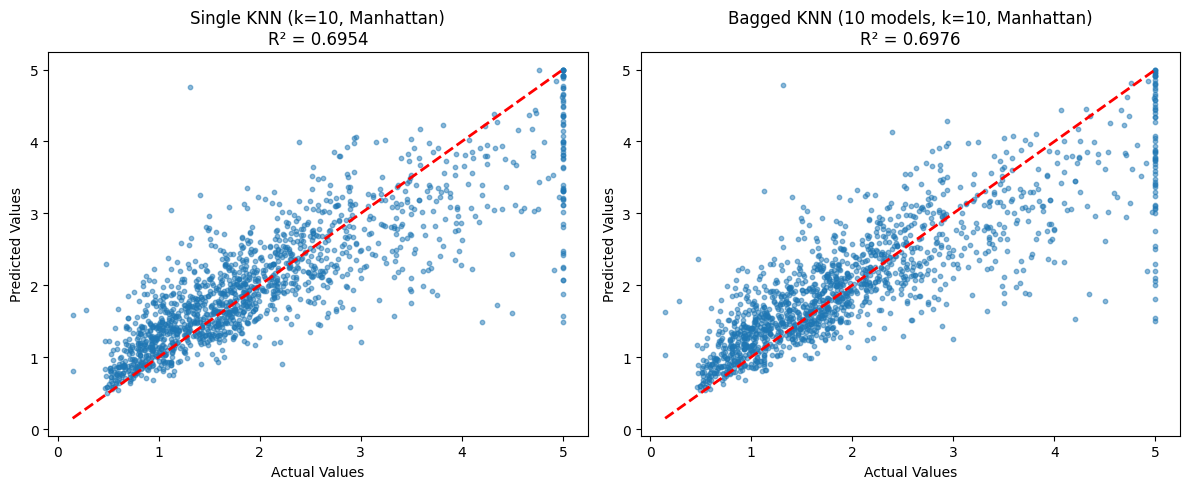

In [68]:
# Predicted vs Actual - Single KNN vs Bagged KNN
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Single KNN (best: k=10, Manhattan)
ax = axes[0]
y_pred = bagging_results['single_manhattan_k10']['y_pred']
r2 = bagging_results['single_manhattan_k10']['r2']
ax.scatter(y_test, y_pred, alpha=0.5, s=10)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title(f'Single KNN (k=10, Manhattan)\nR² = {r2:.4f}')

# Bagged KNN (best: 10 models, k=10, Manhattan)
ax = axes[1]
y_pred = bagging_results['bagged_10_manhattan_k10']['y_pred']
r2 = bagging_results['bagged_10_manhattan_k10']['r2']
ax.scatter(y_test, y_pred, alpha=0.5, s=10)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title(f'Bagged KNN (10 models, k=10, Manhattan)\nR² = {r2:.4f}')

plt.tight_layout()
plt.show()

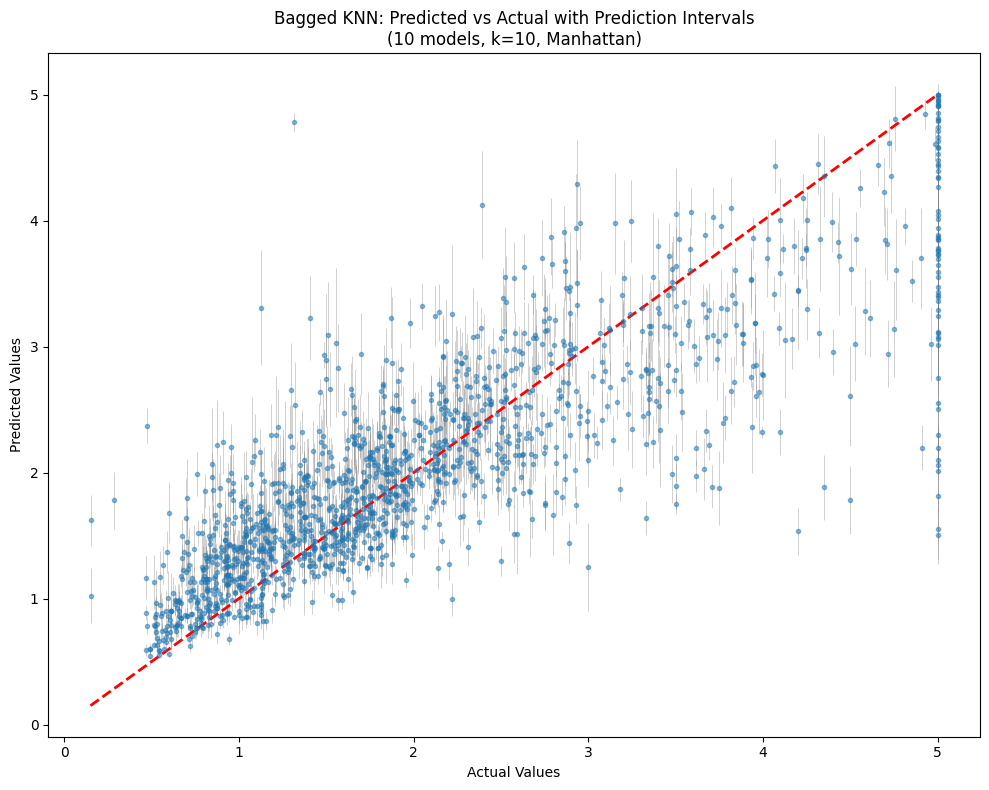

In [69]:
# I wasn't 100% sure exactly what you meant, but my best interpretation was plotting error bars on the scatter plot
# Predicted vs Actual with prediction intervals (error bars)
fig, ax = plt.subplots(figsize=(10, 8))

y_pred = bagging_results['bagged_10_manhattan_k10']['y_pred']
y_std = bagging_results['bagged_10_manhattan_k10']['y_std']

# Scatter with error bars
ax.errorbar(y_test, y_pred, yerr=y_std, fmt='o', alpha=0.5, markersize=3, 
            ecolor='gray', elinewidth=0.5, capsize=0)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Bagged KNN: Predicted vs Actual with Prediction Intervals\n(10 models, k=10, Manhattan)')

plt.tight_layout()
plt.show()

Woah, our prediction seems to be significantly better the lower the total value of the house was; largely because there seems to be much more houses that are priced in that range of 80-250k USD. The higher the price of the house, the worse it seems to perform. There also appears to be a strange anomaly occurring at the 500k house price mark. 

### Analysis 

Single vs Bagged KNN: 

Bagging improved performance, but only slightly. Our best bagged model (10 models, k=10, Manhattan) achieves $R^2$=0.698 compared to $R^2$=0.695 for the single KNN with the same k and distance metric. The improvement is only about 0.3% better in variance explained.

What made a bigger impact seemed to be our choice in k. With k=2, it was too small and performed consistently worse than the other k values we tested in k=5 and k=10. 

Somewhat interestingly, bagging with only 2 models sometimes performs worse than a single KNN. With Euclidean k=5, the single KNN achieves $R^2$=0.666 while the 2-model ensemble only achieves $R^2$=0.651. This is because 2 models isn't enough to reliably reduce variance; since bootstrap sampling introduces noise, taking an average of 2 models doesn't sufficiently justify the additional noise we introduced. 

We also noticed a diminishing return in terms of increasing the number of models and the overall performance. The jump from 2 to 5 models was more improvement than the jump from 5 to 10 models. We expect this as bagging follows a roughly $\frac{1}{n}$ relationship.

Effect of Ensemble Size on Variance Reduction

Our average prediction standard deviation column is seemingly giving us contradictory information: the results show that, when comparing the same k value, the average standard deviation (of the individual regressors) increases as the ensemble grows larger. 

However, larger ensembles build more diverse models from different bootstrap samples, which increases their individual variance, *even as* their average prediction error (variance of the ensemble mean) decreases. The final ensemble prediction is more stable with additional models, even though the measured disagreement between individual models increases. This is because we're averaging over more diverse predictions, and by the law of large numbers, the mean becomes more reliable.

Bagging provides small improvements over single KNN, with diminishing returns as ensemble size increases. The best configuration overall is 10 models, k=10, Manhattan distance with:

RMSE: 0.631 (lowest)
MAE: 0.439 (lowest)
R²: 0.698 (highest)

The improvement from bagging is more noticeable when using smaller k values, which makes sense theoretically. Smaller k means higher variance (more sensitive to individual training points), and bagging specifically targets variance reduction. When k is already large (k=10), the single KNN already has relatively low variance, so there's less room for bagging to help.

## Sources Used

General:
- https://www.cmor-faculty.rice.edu/~heinken/latex/symbols.pdf

Gradient Boosting with Decision Trees 
- https://www.geeksforgeeks.org/python/numpy-random-choice-in-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
- https://medium.com/pythoneers/vectorization-in-python-an-alternative-to-python-loops-2728d6d7cd3e
  


Random Forest Implementation:
- https://www.geeksforgeeks.org/machine-learning/hyperparameters-of-random-forest-classifier/#



Bagging with K-Nearest Neighbors Regression:
- https://www.deep-ml.com/problems/173
- https://claude.ai/share/e3789079-cec0-4216-b5ad-53d0828ab9c0

### Disclosure 

Claude was used for conceptual understanding and learning, but not for code (unless explicitly marked). The Markdown explanations may be inspired in part by conversations with Claude, but never Copy-pasted.